## GPU acceleration

In this part we will use PyCuda to accelerate the computation of our automata.

### Installation

On ubuntu 14.04 amd64 with an NVIDIA Quadro 600.
First I installed CUDA by following the instructions in this website and it worked perfectly [link](http://www.r-tutor.com/gpu-computing/cuda-installation/cuda7.0-ubuntu).



`
$lsb_release -a
Distributor ID:	Ubuntu
Description:	Ubuntu 14.04.2 LTS
Release:	14.04
Codename:	trusty
`

`
glxinfo | grep direct
glxinfo | grep OpenGL
`

$sudo pip3 install pycuda

In [1]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
from pycuda.compiler import SourceModule
%load_ext autoreload
%autoreload 2

In [4]:
(free,total)=cuda.mem_get_info()
print(free,total)
print("Global memory occupancy:%f%% free"%(free*100/total))
#cuda.Device(0).get_attributes()

618135552 1009713152
Global memory occupancy:61.218926% free


In [5]:
#import previous notebook but now we use booleans
from gameOfLifeBool import GameOfLifeBool
from gameOfLife_test import runGOFTest

In [6]:
class GameOfLifeGPU(GameOfLifeBool):
    def __init__(self,shape):
        super().__init__(shape)
        self._init_cuda_mem()
        self.init_cuda()
    
    def _init_cuda_mem(self):
        array = self._buffers[int(self._pointer)]
        (before,total)=cuda.mem_get_info()
        
    
        self._cuda_buffers = [cuda.mem_alloc(array.nbytes),cuda.mem_alloc(array.nbytes)]
        (after,total)=cuda.mem_get_info()
        print("allocated ",before-after)
        
        thX  = 16
        thY  = 16
        assert(self.shape[0] <= 16 or (self.shape[0] % thX == 0))
        assert(self.shape[1] <= 16 or (self.shape[1] % thX == 0))
        grid_height = max(1,self.shape[0]//thY)
        grid_width =  max(1,self.shape[1]//thX)
        
        self._block = (thY,thX,1)
        self._grid = (grid_height,grid_width)
        print(self._grid)
        
    
    def set(self,array):
        super().set(array)
        gpu_array = self._get_gpu()
        cuda.memcpy_htod(gpu_array,array)
    
    def _get_gpu(self):
        return self._cuda_buffers[int(self._pointer)]
            
    def get(self):
        array = super().get()
        gpu_array = self._get_gpu()
        cuda.memcpy_dtoh(array,gpu_array)
        return array
    
        
    
    
    
    def init_cuda(self):
        mod = SourceModule("""
        __global__ void bit_gol(const bool *data, bool *dataRes,
            const uint nbRow,const uint nbCol)
        {
            unsigned int x = blockIdx.x * blockDim.x +  threadIdx.x;
            unsigned int y = blockIdx.y * blockDim.y +  threadIdx.y;
            const unsigned int i = x + y*nbCol;
            unsigned int N; /* Nb cell alive*/
            if(x > 0 && y > 0 && x < nbCol-1 && y < nbRow-1){
                N = ( data[x-1 + (y-1)*nbCol] + data[x + (y-1)*nbCol] + data[x+1 + (y-1)*nbCol] +
                      data[x-1 + ( y )*nbCol] +                       + data[x+1 + ( y )*nbCol] +
                      data[x-1 + (y+1)*nbCol] + data[x + (y+1)*nbCol] + data[x+1 + (y+1)*nbCol] );
                      
                dataRes[i] = ( data[i] & (((N==2) | (N==3)))) /*survive*/
                            | (!data[i] & N==3);               /*birth*/
            }else if((x == 0) || (y == 0) || (x == (nbCol-1)) || (y = (nbRow-1))){
                 dataRes[i] = false;
            }
        }
        """)

        self.cuda_func = mod.get_function("bit_gol")
    
    def _step(self,X,Y):
        self.cuda_func(
                X,Y ,np.uint32(self.shape[0]),np.uint32(self.shape[1]),
                block=self._block, grid=self._grid)

    def run(self,nbIteration=1):
        for i in range(nbIteration):
            X = self._cuda_buffers[int(self._pointer)]
            Y = self._cuda_buffers[int(not(self._pointer))]
            self._step(X,Y)
            self._pointer = not(self._pointer)
        

In [7]:
runGOFTest(GameOfLifeGPU)

.

allocated  1048576
(1, 1)
allocated 

.

 1048576
(1, 1)



----------------------------------------------------------------------
Ran 2 tests in 0.071s

OK


In [9]:
uutGPU = GameOfLifeGPU((1008,1008))
%timeit uutGPU.run(nbIteration=10)

allocated  2097152
(63, 63)
1000 loops, best of 3: 10.9 ms per loop


In [11]:
from utils import plotIterations
import matplotlib.pyplot as plt
%matplotlib inline

Global memory occupancy:71.214383% free
allocated  2097152
(63, 63)


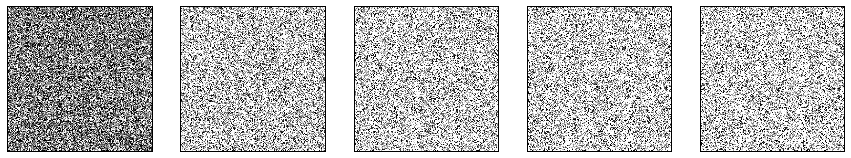

In [12]:
size = 1008
(free,total)=cuda.mem_get_info()
print("Global memory occupancy:%f%% free"%(free*100/total))
shape = (size,size)
uut = GameOfLifeGPU(shape)
plt.figure(figsize=(15,8))
plotIterations(uut,5)

The speed increade by a factor 3 only. This is quite disapointing.

In [13]:
uutGPU = GameOfLifeGPU((10000,10000))
%timeit uutGPU.run(nbIteration=10)

allocated  200015872
(625, 625)
100 loops, best of 3: 880 ms per loop


Factor 10 with a size of 10000x10000